In [1]:
import bert
# from bert import run_classifier
# from bert import optimization
from bert import tokenization
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import hashlib
import os
from tensorflow.python.ops import math_ops

from tensorflow.metrics import accuracy

%matplotlib inline


BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [2]:
tf.enable_eager_execution()

In [3]:
from tensorflow import metrics
n_way = 5
predictions = tf.constant([[1,2],[10,12],[30,30]])
positions = tf.constant([[[1,2],[4,5],[3,5],[3,5],[1,5]],
                        [[10,11],[10,11],[9,12],[3,5],[3,5]],
                        [[30,31],[29,39],[9,12],[3,5],[3,5]]])

In [148]:
_accuracy = span_accuracy(predictions, positions)
_accuracy

<tf.Tensor: id=787, shape=(4,), dtype=bool, numpy=array([ True, False, False,  True])>

In [182]:
#####################
# precision / recall#
#####################
predictions = tf.constant([[0,0], [1,2], [0,0], [30,30]]) # TN, FP, FN, TP,  
positions = tf.constant([[[0,0],[0,0],[0,0],[0,0],[0,0]],
                         [[0,0],[0,0],[0,0],[0,0],[0,0]],
                        [[10,12],[10,11],[9,12],[3,5],[3,5]],
                        [[30,30],[29,39],[9,12],[3,5],[3,5]]])
_accuracy = span_accuracy(predictions, positions)
_equal = tf.cast(math_ops.equal(positions, 0), tf.int64)
labels = tf.reduce_any(tf.not_equal(tf.reduce_sum(_equal, axis=-1), 2), -1)
labels
tp = tf.reduce_sum(tf.cast(math_ops.logical_and(math_ops.equal(_accuracy, True), math_ops.equal(labels, False)), tf.int64))
fp = tf.reduce_sum(tf.cast(math_ops.logical_and(math_ops.equal(_accuracy, True), math_ops.equal(labels, True)), tf.int64))
fn = tf.reduce_sum(tf.cast(math_ops.logical_and(math_ops.equal(_accuracy, False), math_ops.equal(labels, True)), tf.int64))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
precision, recall


(<tf.Tensor: id=1529, shape=(), dtype=float64, numpy=0.5>,
 <tf.Tensor: id=1533, shape=(), dtype=float64, numpy=0.5>)

In [158]:
precision = math_ops.logical_and(math_ops.equal(labels, True), math_ops.equal(predictions, False))

<tf.Tensor: id=882, shape=(4,), dtype=bool, numpy=array([False,  True, False,  True])>

In [12]:
start_l = tf.constant([[0.1, 0.4, 0.5],[0.1, 0.4, 0.5],[0.1, 0.9, 0.5]])
end_l = tf.constant([[0.1, 0.4, 0.5],[0.5, 0.4, 0.1],[0.1, 0.9, 0.5]])

start_l = tf.math.exp(start_l)
end_l = tf.math.exp(end_l)
start_l = tf.expand_dims(start_l, 1)
end_l = tf.expand_dims(end_l, -1)
#TODO: mask end preceeding statt.
logits = start_l * end_l
flat_logits = tf.reshape(logits, shape=[tf.shape(logits)[0], -1])
logits = tf.linalg.LinearOperatorLowerTriangular(logits).to_dense()
flat_logits = tf.reshape(logits, shape=[tf.shape(logits)[0], -1])
_argmax = tf.cast(tf.argmax(flat_logits, axis=-1), dtype=tf.int32)
ix = tf.cast(tf.stack([_argmax % tf.shape(logits)[1], _argmax // tf.shape(logits)[2]], axis=-1), dtype=tf.int64)

In [ ]:
##########################################
### Testing the preprocessing module   ###
##########################################

In [3]:
from preprocessing.preprocessing import convert_example

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                  tokenization_info["do_lower_case"]])

    return bert.tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case)

In [4]:
token = create_tokenizer_from_hub_module()

INFO:tensorflow:Using /var/folders/lc/hb9bf06j1rxbfpk731_nt7g40000gp/T/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
import jsonlines
import re
from preprocessing.preprocessing import FeatureWriter
_train_file = '/Users/deniz/natural_questions/data/v1.0_sample_nq-train-sample.jsonl'
_dev_file = '/Users/deniz/natural_questions/data/v1.0_sample_nq-dev-sample.jsonl'
_train_file_out = re.sub(".jsonl", ".tf_record", _train_file)
train_writer = FeatureWriter(
    filename=_train_file_out,
    mode='train')
with jsonlines.open(_train_file) as reader:
    features, examples = [], []
    for i, example in enumerate(reader):
        if i % 1e3 == 0: tf.logging.info("{}:{}".format(_dev_file, i))
        examples.append(example)
        dt = convert_example(example=example,
                             tokenizer=token,
                             mode='train',
                             max_seq_length=384,
                             doc_stride=128,
                             max_query_length=64,
                             train_writer=train_writer.process_feature)

INFO:tensorflow:/Users/deniz/natural_questions/data/v1.0_sample_nq-dev-sample.jsonl:0
INFO:tensorflow:[(0, (276, 279))]


TypeError: [(276, 279)] has type list, but expected one of: int, long

In [9]:
##########################################
### JSON files  ###
##########################################
a = [(10,20),(10,40)]
b = list(sum(a, ()))


In [128]:
import jsonlines
_train_file = '/Users/deniz/natural_questions/data/v1.0_sample_nq-train-sample.jsonl'
_dev_file = '/Users/deniz/natural_questions/data/v1.0_sample_nq-dev-sample.jsonl'
with jsonlines.open(_train_file) as reader:
    features, train_examples = [], []
    for i, example in enumerate(reader):
        train_examples.append(example['annotations'])

            
_train_file = '/Users/deniz/natural_questions/data/v1.0_sample_nq-train-sample.jsonl'
_dev_file = '/Users/deniz/natural_questions/data/v1.0_sample_nq-dev-sample.jsonl'
with jsonlines.open(_dev_file) as reader:
    features, dev_examples = [], []
    for i, example in enumerate(reader):
        dev_examples.append(example['annotations'])

In [35]:
from collections import Counter
Counter([len(t) for t in train_examples]), Counter([len(t) for t in dev_examples])

(Counter({1: 200}), Counter({5: 200}))

In [129]:
dev_examples[1]

[{'annotation_id': 4831085488325731996,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 11617036854844010808,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 15568189459232688585,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 10333790090572531291,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 15453965265736125661,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte':

In [43]:
# multiple short answers per annotation
Counter([len(t[0]['short_answers']) for t in train_examples])

Counter({0: 130, 1: 69, 3: 1})

In [17]:
dev_examples[-2]['annotations']

[{'annotation_id': 10957934160137332476,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 2807704282985816749,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 5129692602407601925,
  'long_answer': {'candidate_index': 0,
   'end_byte': 57005,
   'end_token': 122,
   'start_byte': 56251,
   'start_token': 43},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 4965838886380681126,
  'long_answer': {'candidate_index': 90,
   'end_byte': 104818,
   'end_token': 4593,
   'start_byte': 104066,
   'start_token': 4485},
  'short_answers': [{'end_byte': 104576,
    'end_token': 4570,
    'start_byte': 104572,
    'start_token': 4569},
   {'end_byte': 104639,
    'end_token': 4572,
    'star

In [20]:
feature = features[10]
feature.example_id

-2975172535563055798

In [27]:
def test(i):
    feature = features[i]
    example_id = feature.example_id
    example = [x for x in examples if x['example_id'] == example_id][0]
    return feature, example  

In [72]:
def get_annotations(example):
    """
    if short, else long
    """
    annotation = example['annotations'][0]
    end_byte_ix, start_byte_ix = None, None
    start_token, end_token = None, None
    if annotation['short_answers']:
        end_byte_ix = annotation['short_answers'][0]['end_byte']
        start_token = annotation['short_answers'][0]['start_token']
        end_token = annotation['short_answers'][0]['end_token']
        start_byte_ix = annotation['short_answers'][0]['start_byte']
    else:
        end_byte_ix = annotation['long_answer']['end_byte']
        start_byte_ix = annotation['long_answer']['start_byte']
        start_token = annotation['long_answer']['start_token']
        end_token = annotation['long_answer']['end_token']
    return {'end_byte_ix': end_byte_ix, 
            'start_byte_ix': start_byte_ix,
            'start_token': start_token,
            'end_token': end_token}

In [131]:
def _validate(i):
    # get the feature and example the feature is derived from.
    feature, example = test(i)
    # get the ground truth annotations.
    gt = get_annotations(example)
    # get start byte and end bytes for targets.
    if feature.targets[0] == 0:
        return (i, True)
    start_bytes = feature.start_bytes[feature.targets[0]]
    end_bytes = feature.end_bytes[feature.targets[1]]
    if start_bytes == gt['start_byte_ix'] and end_bytes == gt['end_byte_ix']:
        return (i,True)
    else:
        return (i, False)

In [127]:
feature, example = test(1)
gt = get_annotations(example)
print(gt)
start_bytes = feature.start_bytes[feature.targets[0]]
end_bytes = feature.end_bytes[feature.targets[1]]
feature.targets, start_bytes, end_bytes
_validate(1)

{'end_byte_ix': 96731, 'start_byte_ix': 96715, 'start_token': 3521, 'end_token': 3525}
True
True


(1, True)

In [139]:
ix = []
for i in range(len(features)):
    _assertion =  _validate(i)
    if not _assertion[1]:
        ix.append(i)      

In [150]:
# assertion fails
feature, example = test(ix[2])
gt = get_annotations(example)
print('ground truth')
print(gt)
start_bytes = feature.start_bytes[feature.targets[0]]
end_bytes = feature.end_bytes[feature.targets[1]]
start_bytes, end_bytes

ground truth
{'end_byte_ix': 55798, 'start_byte_ix': 55137, 'start_token': 893, 'end_token': 1001}


(55140, 55794)

In [151]:
example['annotations']

[{'annotation_id': 13306123758205215060,
  'long_answer': {'candidate_index': 32,
   'end_byte': 55798,
   'end_token': 1001,
   'start_byte': 55137,
   'start_token': 893},
  'short_answers': [],
  'yes_no_answer': 'NONE'}]

In [152]:
ann = get_annotations(example)
[t for t in example['document_tokens'] if t['start_byte'] >= ann['start_byte_ix'] and t['end_byte'] <= ann['end_byte_ix']]

[{'end_byte': 55140, 'html_token': True, 'start_byte': 55137, 'token': '<P>'},
 {'end_byte': 55143, 'html_token': False, 'start_byte': 55140, 'token': 'The'},
 {'end_byte': 55153,
  'html_token': False,
  'start_byte': 55144,
  'token': 'marooning'},
 {'end_byte': 55156, 'html_token': False, 'start_byte': 55154, 'token': 'of'},
 {'end_byte': 55167,
  'html_token': False,
  'start_byte': 55160,
  'token': 'Voyager'},
 {'end_byte': 55174, 'html_token': False, 'start_byte': 55172, 'token': 'in'},
 {'end_byte': 55178, 'html_token': False, 'start_byte': 55175, 'token': 'the'},
 {'end_byte': 55184,
  'html_token': False,
  'start_byte': 55179,
  'token': 'Delta'},
 {'end_byte': 55193,
  'html_token': False,
  'start_byte': 55185,
  'token': 'Quadrant'},
 {'end_byte': 55202,
  'html_token': False,
  'start_byte': 55194,
  'token': 'provided'},
 {'end_byte': 55208,
  'html_token': False,
  'start_byte': 55203,
  'token': 'Paris'},
 {'end_byte': 55213,
  'html_token': False,
  'start_byte': 552

# TF Records

In [4]:
from run_nq import input_fn_builder
seq_length=384

name_to_features = {
  "input_ids": tf.FixedLenFeature([], tf.int64),
  "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
  "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
  "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
  "start_bytes": tf.FixedLenFeature([seq_length], tf.int64),
  "end_bytes": tf.FixedLenFeature([seq_length], tf.int64),
}
name_to_features["positions"] = tf.FixedLenFeature([2], tf.int64)

def _decode_record(record):
  """Decodes a record to a TensorFlow example."""
  example = tf.parse_single_example(record, name_to_features)
  return example

In [5]:
import os
import run_nq
bert_data_dir = '/data/nq/natural_questions/v1.0/'
_train_path = '/Users/deniz/natural_questions/data/'
_dev_path = os.path.join(bert_data_dir, 'dev')
_train_path = os.path.join(bert_data_dir, 'train')
train_files = [os.path.join(_train_path, _file) for _file in os.listdir(_train_path) if _file.endswith(".tf_record")]

train_input_fn = input_fn_builder(
  input_files=train_files,
  seq_length=384,
  mode='train')

INFO:tensorflow:train


In [9]:
_gen = train_input_fn({'batch_size':8})
_iter = _gen.make_one_shot_iterator()

In [10]:
nb_null_answers = 0
nb_answers = 0
for i in range(2000):
    _batch = _iter.get_next()
    positions = _batch['positions'].numpy()
    nb_null_answers += (positions == 0).all(axis=1).sum()
    nb_answers += positions.shape[0]

DataLossError: truncated record at 40244930 [Op:IteratorGetNextSync]

In [ ]:
nb_null_answers / nb_answers

In [ ]:
# DOWNSASMPLE 500 -> 0.11925

In [12]:
(a == 0).all(axis=1)

array([False, False, False, False, False, False, False, False])

In [26]:
# import tensorflow as tf
# dt = tf.data.TFRecordDataset(train_files)
# dt = dt.map(_decode_record, num_parallel_calls=10)
# dt = dt.shuffle(buffer_size=100)
# dt = dt.batch(32)
# it = dt.make_one_shot_iterator()
# a = it.get_next()
# a['input_ids']

In [2]:
#############################
######### INFERENCE    ######
#############################

from run_nq import input_fn_builder
bert_data_dir = '/data/nq/natural_questions/v1.0/'
from bert import modeling
from run_nq import model_fn_builder
# prediction
bert_config = modeling.BertConfig.from_json_file('model/uncased_L-12_H-768_A-12/bert_config.json')

_dev_path = os.path.join(bert_data_dir, 'dev')
_train_path = os.path.join(bert_data_dir, 'train')
_predict_path = os.path.join(bert_data_dir, 'predict')

config = tf.estimator.RunConfig(
  save_checkpoints_steps=10, # this also sets when eval starts
  save_summary_steps=50,
  keep_checkpoint_max=10, #train_and_eval does not save the best models, but the most recent ones.
  model_dir='/home/deniz/repos/natural_questions/model/training'
)


model_fn = model_fn_builder(
  bert_config=bert_config,
  init_checkpoint='/home/deniz/repos/natural_questions/model/training',
  learning_rate=1e-5,
  num_train_steps=10,
  num_warmup_steps=0,
  use_tpu=False,
  use_one_hot_embeddings=False)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=config,
  params={'batch_size':8})


predict_files = [os.path.join(_train_path, _file) for _file in os.listdir(_train_path) if
                 _file.endswith(".tf_record")]
predict_input_fn = input_fn_builder(
    input_files=predict_files,
    seq_length=384,
    is_training=False,
    mode='train')

INFO:tensorflow:Using config: {'_model_dir': '/home/deniz/repos/natural_questions/model/training', '_tf_random_seed': None, '_save_summary_steps': 50, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 10, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f26bc44e278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [3]:
batch_result = estimator.predict(predict_input_fn)
batch_result

<generator object Estimator.predict at 0x7f26bc43ef10>

In [12]:
_batch_result = next(batch_result)

In [13]:
np.argmax(_batch_result['y_pred_start']), np.argmax(_batch_result['y_pred_end'])

(278, 342)

In [14]:
# GROUND TRUTH
_batch_result['start_positions'], _batch_result['end_positions']

(295, 306)

In [25]:
import pandas as pd

In [35]:
start_logits = pd.DataFrame([(i, score) for i, score in enumerate(_batch_result['start_logits']) if score > 0 ])
start_logits

,0,1
0,0,0.176463
1,295,2.008699
2,298,3.161665
3,299,4.229423
4,302,0.544027


In [36]:
end_logits = pd.DataFrame([(i, score) for i, score in enumerate(_batch_result['end_logits']) if score > 0 ])
end_logits

,0,1
0,0,0.770081
1,306,6.001465
2,325,0.931091
3,335,0.933333
4,356,0.244597
5,357,2.219360


In [34]:
np.exp(-20)

2.061153622438558e-09

In [ ]:
#########################
#####accuracy metric#####
#########################

tf.reset_default_graph()
init = tf.global_variables_initializer()

In [ ]:
from tensorflow import metrics

# Start training
with tf.Session() as sess:
    sess.run(init)
    start_ix = tf.expand_dims(tf.constant([10,20,30,40,50]),1)
    end_ix =  tf.expand_dims(tf.constant([10,20,30,40,50]),1)
    start_positions = tf.expand_dims(tf.constant([10,20,30,40,50]),1)
    end_positions = tf.expand_dims(tf.constant([10,20,30,40,60]),1) #80% accuracy

    y_pred = tf.concat([start_ix, end_ix], axis=-1) #[batch_size, 2]
    y_true = tf.concat([start_positions, end_positions], axis=-1) #[batch_size, 2]
    acc = tf.reduce_all(math_ops.equal(y_true, y_pred), axis=-1)
    is_correct = math_ops.to_float(acc)
    a,b = metrics.mean(is_correct)
    
    
    running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES)
    running_vars_initializer = tf.variables_initializer(var_list=running_vars)
    
    sess.run(running_vars_initializer)
    
    # initial op
    a_out = sess.run(a)
    # update op
    b_out = sess.run(b)

In [ ]:
a_out, b_out

In [ ]:
#from preprocessing.preprocessing import *
from run_nq import *

In [ ]:
bert_data_dir = "/data/nq/natural_questions/v1.0/sample_train"

In [ ]:

train_files = [_file for _file in os.listdir(bert_data_dir) if _file.endswith(".tf_record")]
_file_path = [os.path.join(bert_data_dir, _file) for _file in train_files]
[tf.gfile.MakeDirs(_dir) for _dir in [_train_path, _dev_path]]
print(_file_path)
train_input_fn = input_fn_builder(
    input_file=_file_path,
    seq_length=512,
    is_training=True,
    drop_remainder=True)

In [ ]:
params = {}
params['batch_size'] = 32
_iter = train_input_fn(params)

In [ ]:
_iter = _iter.make_one_shot_iterator()

In [ ]:
out = _iter.get_next()
out.keys()

In [ ]:
#dt['document_tokens'][:10]

In [ ]:
dt['annotations']

In [ ]:
outputs = convert_examples_to_features(dt, tokenizer, 512)

In [ ]:
# answer
if outputs:
    print(outputs[0].targets)

In [ ]:
{i: t for i, t in enumerate(outputs[0].tokens) if i >= outputs[0].targets[0][0] and i <= outputs[0].targets[0][1]}

In [ ]:
short_answer_start = dt['annotations'][0]['short_answers'][0]['start_byte']
short_answer_end = dt['annotations'][0]['short_answers'][0]['end_byte']
[t for t in dt['document_tokens'] if t['start_byte'] >= short_answer_start and t['end_byte'] <= short_answer_end]

In [ ]:
dt['annotations']

In [ ]:
long_answer_start = dt['annotations'][0]['long_answer']['start_byte']
long_answer_end = dt['annotations'][0]['long_answer']['end_byte']
end = dt['annotations'][0]['long_answer']['end_token']+1
start = dt['annotations'][0]['long_answer']['start_token']
dt['document_tokens'][start:end]

In [ ]:
dt = data[0]

In [ ]:
dt.keys()

In [ ]:
dt['document_tokens'][:100]

In [ ]:
#set([t['token'] for dt in data for t in dt['document_tokens'] if t['html_token']])

In [ ]:
from IPython.core.display import display, HTML
display(HTML(dt['document_html']))

In [ ]:
#dt['long_answer_candidates']

In [ ]:
dt['question_tokens']

In [ ]:
dt['annotations'][0]

In [ ]:
tokens = dt['document_tokens']

In [ ]:
[token for token in tokens if token['start_byte'] >= start_byte_ix and token['end_byte'] <= end_byte_ix]

In [2]:
########################
### post-processing   ##
########################
import json
predictions_file = '/home/deniz/repos/natural_questions/model/training/predictions.json'
candidate_file = '/home/deniz/repos/natural_questions/model/training/candidates.json'
with open(candidate_file) as f:
    candidates = json.load(f)
candidates = {int(k): v for k,v  in candidates.items()}
with open(predictions_file) as f:
    all_span_predictions = json.load(f)
import pandas as pd
#predictions.groupby('example_id').size().value_counts()

In [3]:
# number of eaxmples predictions generated for vs number of examples in dev dataset.
example_ids = set([p['example_id'] for p in all_span_predictions])
len(example_ids)

7830

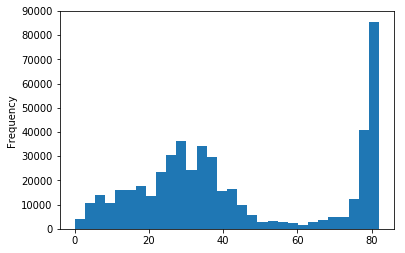

In [4]:
pred = pd.DataFrame(all_span_predictions)
pred['score'].plot.hist(bins=30)

In [5]:
pred.groupby((pred['start_byte'] == 0) & (pred['end_byte'] == 0))['score'].describe().T

,False,True
count,54379.000000,440849.000000
mean,18.358484,46.591461
std,12.192034,25.364973
min,0.000000,0.000000
25%,9.000000,27.000000
50%,16.000000,37.000000
75%,25.000000,78.000000
max,71.000000,82.000000


In [6]:
example_ids_with_answers = set(pred[(pred['start_byte'] > 0) & (pred['end_byte'] > 0)]['example_id'])
len(example_ids_with_answers)

7348

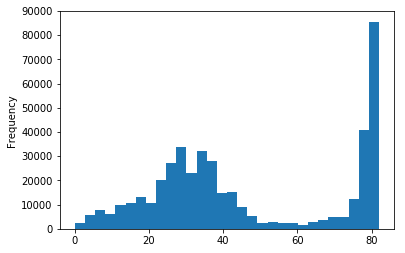

In [12]:
pred[(pred['start_byte'] == 0) & (pred['end_byte'] == 0)]['score'].plot.hist(bins=30)

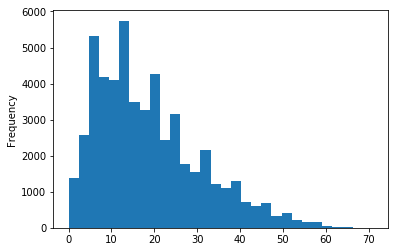

In [13]:
pred[pred['start_byte'] > 0]['score'].plot.hist(bins=30)

In [14]:
from processing.postprocessing import extract_prediction

In [15]:
#_predictions, missing_example_ids, processed_example_ids, no_answer_example_ids = extract_prediction(all_span_predictions, candidates)
predictions = extract_prediction(all_span_predictions, candidates)
df = pd.DataFrame(predictions['predictions'])
# len(example_ids), len(predictions['predictions'])
df.shape

INFO:tensorflow:decorated 7108 examples with answers
INFO:tensorflow:decorated 722 examples with null answers
INFO:tensorflow:nb_null_answers_override 3193.0
INFO:tensorflow:remove_answers_cutoff 44.92121553179516


(7830, 7)

In [17]:
answer_scores = []
remove_answers_cutoff = 100 * 3193.0 / 7108
print(remove_answers_cutoff)
for prediction in predictions['predictions']:
  if not prediction['is_null_answer']:
    answer_scores.append(prediction['short_answers_score'])
cutoff = np.percentile(answer_scores, remove_answers_cutoff)
np.sum(answer_scores >= cutoff)

44.92121553179516


3888

In [18]:
df.groupby('is_null_answer').size()

is_null_answer
False    3888
True     3942
dtype: int64

In [19]:
df[df['example_id'] == 5679714123144678326]['short_answers'].to_dict(), df[df['example_id'] == 5679714123144678326]['short_answers_score']

({4000: [{'start_byte': -1,
    'end_byte': -1,
    'start_token': -1,
    'end_token': -1}]},
 4000    0
 Name: short_answers_score, dtype: int64)

In [14]:
_spans = [pr for pr in all_span_predictions if pr['example_id'] == 5679714123144678326 and pr['start_byte'] > 0 ]
_spans

[{'example_id': 5679714123144678326,
  'start_byte': 59570,
  'end_byte': 60096,
  'score': 6},
 {'example_id': 5679714123144678326,
  'start_byte': 66140,
  'end_byte': 66446,
  'score': 7},
 {'example_id': 5679714123144678326,
  'start_byte': 68986,
  'end_byte': 68994,
  'score': 9},
 {'example_id': 5679714123144678326,
  'start_byte': 68330,
  'end_byte': 68733,
  'score': 5},
 {'example_id': 5679714123144678326,
  'start_byte': 65835,
  'end_byte': 66591,
  'score': 17},
 {'example_id': 5679714123144678326,
  'start_byte': 58882,
  'end_byte': 60096,
  'score': 4},
 {'example_id': 5679714123144678326,
  'start_byte': 69921,
  'end_byte': 70730,
  'score': 8},
 {'example_id': 5679714123144678326,
  'start_byte': 60418,
  'end_byte': 61760,
  'score': 5},
 {'example_id': 5679714123144678326,
  'start_byte': 68986,
  'end_byte': 68994,
  'score': 6}]

In [18]:
df.groupby('is_null_answer')['short_answers_score'].describe().T

is_null_answer,False,True
count,7108.0,722.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [23]:
df.sort_values('short_answers_score').head(1000).tail(1)

,example_id,is_null_answer,long_answer,long_answer_score,short_answers,short_answers_score,yes_no_answer
4000,5679714123144678326,False,"{'start_byte': 68327, 'end_byte': 69134, 'star...",6.0,"[{'start_byte': 68986, 'end_byte': 68994, 'sta...",6.0,NONE


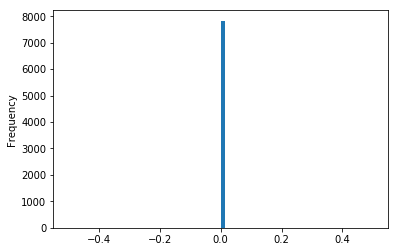

In [18]:
df['short_answers_score'].plot.hist(bins=80)

In [19]:
predictions['predictions'][:5]

[{'short_answers_score': 0,
  'long_answer_score': 0,
  'short_answers': [{'start_byte': 54771,
    'end_byte': 54793,
    'start_token': -1,
    'end_token': -1}],
  'long_answer': {'start_byte': 52946,
   'end_byte': 54876,
   'start_token': -1,
   'end_token': -1},
  'yes_no_answer': 'NONE',
  'example_id': 5225754983651766092,
  'is_null_answer': False},
 {'short_answers_score': 0,
  'long_answer_score': 0,
  'short_answers': [{'start_byte': 37907,
    'end_byte': 37930,
    'start_token': -1,
    'end_token': -1}],
  'long_answer': {'start_byte': 37786,
   'end_byte': 39086,
   'start_token': -1,
   'end_token': -1},
  'yes_no_answer': 'NONE',
  'example_id': -3290814144789249484,
  'is_null_answer': False},
 {'short_answers_score': 0,
  'long_answer_score': 0,
  'short_answers': [{'start_byte': 59312,
    'end_byte': 59331,
    'start_token': -1,
    'end_token': -1}],
  'long_answer': {'start_byte': 58953,
   'end_byte': 60000,
   'start_token': -1,
   'end_token': -1},
  'yes_n

In [20]:
predictions_file = '/home/deniz/repos/natural_questions/model/training/final_predictions.json'
with tf.gfile.Open(predictions_file, "w") as f:
  json.dump(predictions, f, indent=4)